## <center> AstroStatistics and Cosmology - Homework 1

### <center> Due on 10$^{th}$ November 2024   -  Lorenzo Cavezza 2130648

In [1]:
# Importing the necessary libraries

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.spatial.distance import jensenshannon

### Exercise 1

Consider the coin tossing example, discussed in the first lecture. Simulate $1000$ tosses of the coins, setting $H = 0.3$. Consider a uniform prior and
update the posterior at each toss. Plot the resulting posterior after 1, 50, 100, 300, 700, 1000 tosses. Repeat the simulated experiment by setting a Gaussian prior centered in $H = 0.5$, with standard deviation $\sigma$ = 0.1. Do both posteriors converge a similar distribution in the end? What does that mean? Which posterior converges faster and why?

### Solution
I decided to compute the posteriors as averages of a high number of replicas of the 1000 tosses (10k), since the variability rendered by the low number of tosses would have otherwise deemed the task at hand unrigorous:

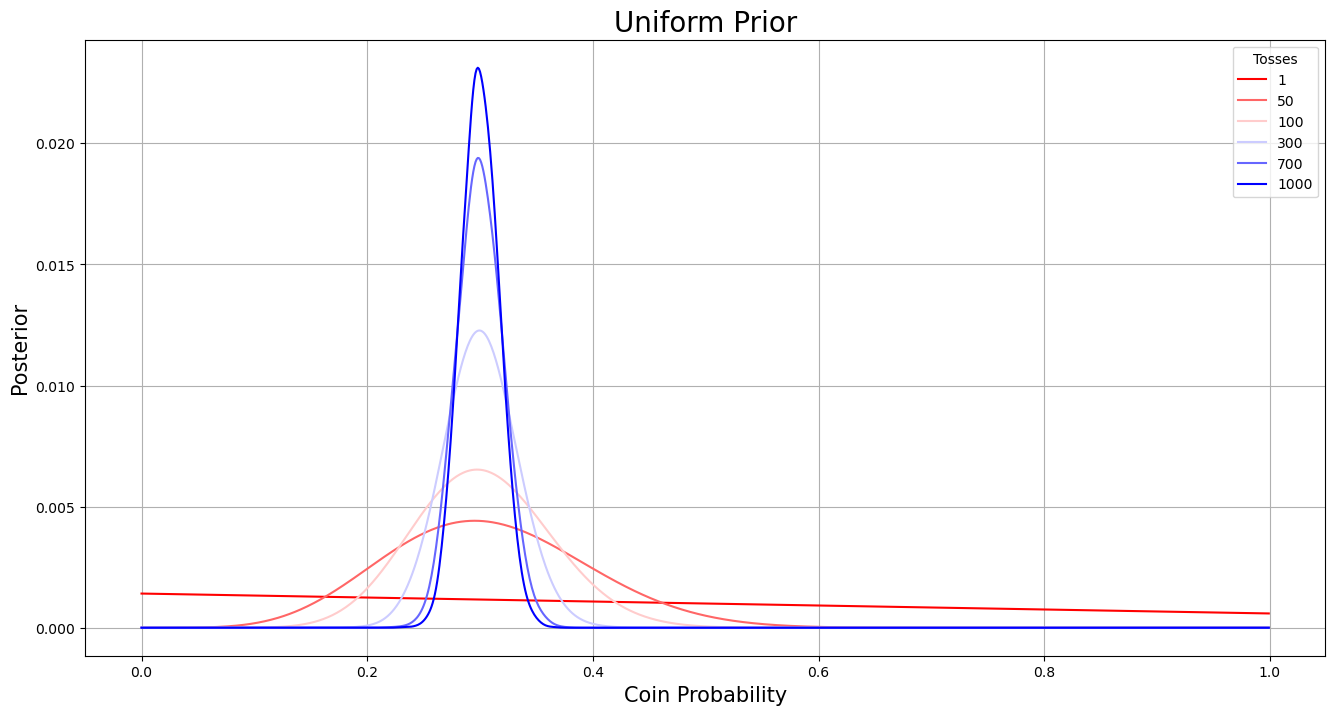

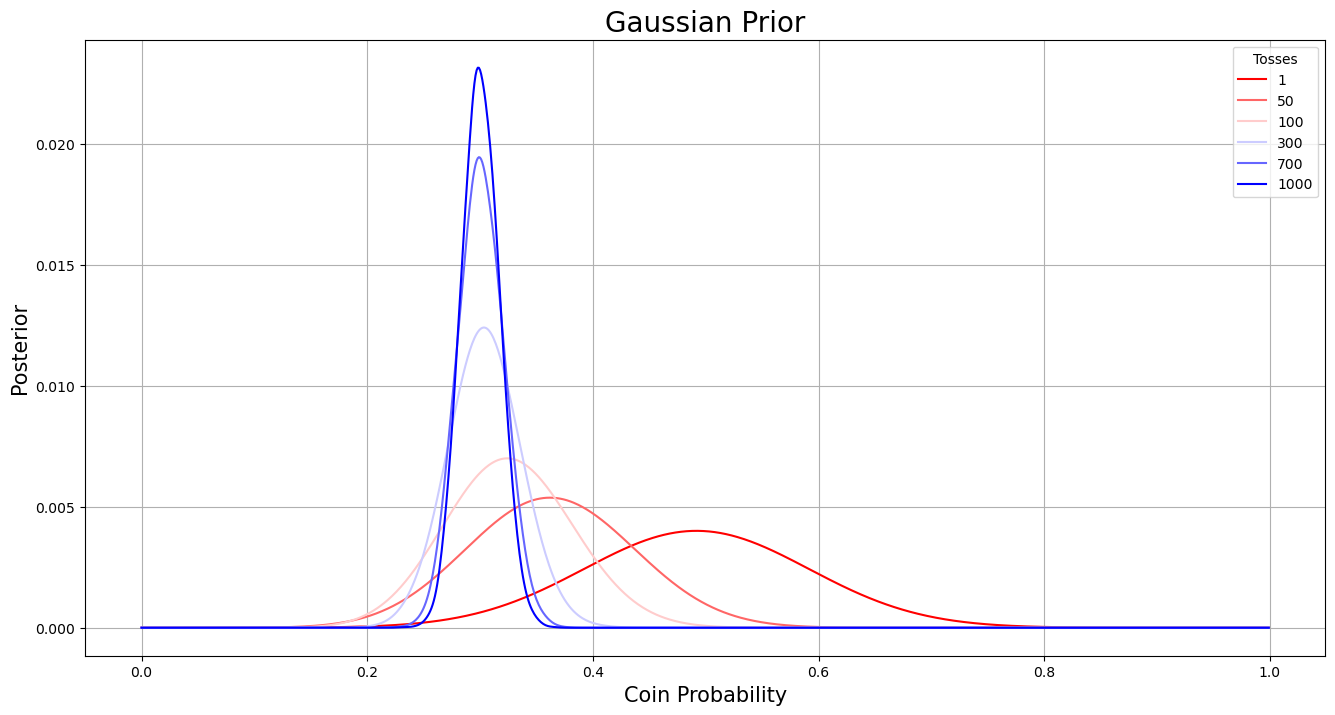

In [2]:
replicas = 10000

#how often I update the posterior, it's not at every toss because the computing time would have been too much otherwise
update_rate = 50 

# Defining pdfs

def binomial(x, n, s): #binomial distribution unnormalized
    return (pow(x, s) * pow((1 - x), n - s))

def uniform_prior(x, replicas):
    return (np.tile(sp.stats.uniform.pdf(x)[:, np.newaxis], replicas))

def gaussian_prior(x, mu, sigma, replicas): #normal prior
    return (np.column_stack([sp.stats.norm.pdf(x, mu, sigma) for i in range(replicas)]))

def likelihood(x, tosses, toss_considered): #binomial likelihood
    toss_list = tosses[0 : toss_considered]
    s = np.sum(toss_list, axis=0)
    return (binomial(np.tile(x[:, np.newaxis], replicas), toss_considered, s))

def normalize(post): #normalizer
    area = np.sum(post, axis=0)
    return (post/area)

def posterior (x, tosses, plots, prior):
    post = []
    for considered in range(len(plots)):
        newpost = normalize(likelihood(x, tosses, plots[considered]) * prior)
        prior = newpost 
        post.append(normalize(np.mean(newpost, axis=1)))
    return (post)

# Plotting
def plotting (x, posteriors, prior, plots):
    fig, ax = plt.subplots(figsize=(16,8))
    cmap = mpl.colormaps['bwr_r']
    colors = cmap(np.linspace(0, 1, len(posteriors)))
    for i,(p,color) in enumerate(zip(posteriors,colors)):
        ax.plot(x_axis, p, color=color, label=plots[i].astype('str'))
    ax.legend(title = 'Tosses')
    ax.set_xlabel('Coin Probability',fontsize=15)
    ax.set_ylabel('Posterior',fontsize=15)
    ax.set_title(prior + ' Prior',fontsize=20)
    ax.xaxis.grid(True, which='both')
    ax.yaxis.grid(True, which='major')
    


H = 0.3
mean_normal = 0.5
sig_normal = 0.1
tosses = np.random.choice(a = 2, p = [1-H,H], size=(1000,replicas))
x_axis =  np.arange(0,1,0.001)

complete_plots = np.array([i for i in range(update_rate,1000+update_rate,update_rate)])
complete_plots = np.insert(complete_plots,0,1)
plots = np.array([1,50,100,300,700,1000])
indices = list(np.where(np.isin(complete_plots, plots))[0])

post_uniform = posterior(x_axis,tosses,complete_plots,uniform_prior(x_axis,replicas))
post_normal = posterior(x_axis,tosses,complete_plots,gaussian_prior(x_axis,mean_normal,sig_normal,replicas))
plotting(x_axis,np.array([post_uniform[i] for i in indices]),'Uniform',plots)
plotting(x_axis,np.array([post_normal[i] for i in indices]),'Gaussian',plots)

Clearly the two posteriors converge to the same one, namely a normal one peaked in $0.3$, the actual coin tossing probability used. In order to asses which prior allows a faster convergence I compute the Jensen-Shannon distance of each posterior from an 'ideal' one, that is a rather peaked gaussian distribution centered on our chosen coin tossing probability (I therefore chose 0.3 as a mean and 0.0001 as a sigma). The Jensen-Shannon distance is just the symmetrized and smoothed out Kullback-Leibler divergence.

In [3]:
test_distribution = sp.stats.norm.pdf(x_axis,H,0.0001) #ideal distribution

# Computing the distances

normal_distances = []
uniform_distances = []
for i in range(len(plots)):
    uniform_distances.append(jensenshannon(test_distribution,post_uniform[i]))
    normal_distances.append(jensenshannon(test_distribution,post_normal[i]))

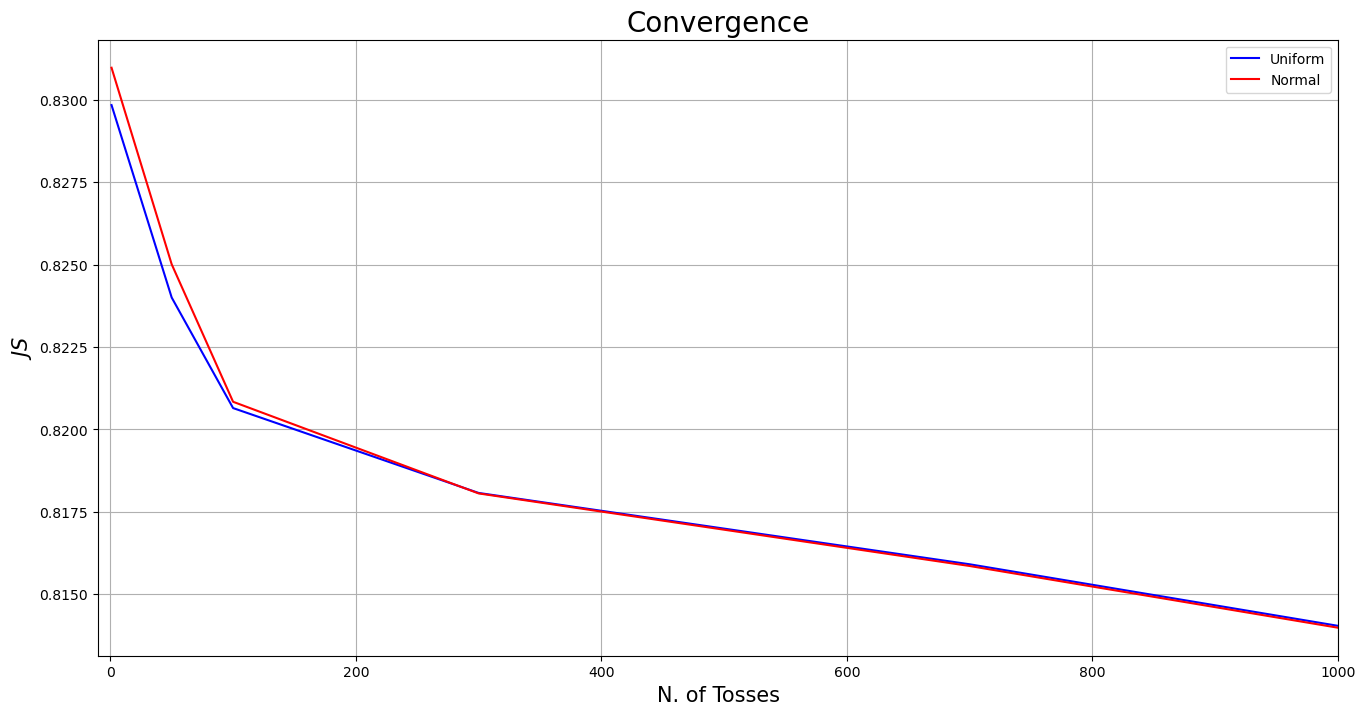

In [4]:
# Plotting

fig,ax = plt.subplots(figsize=(16,8))
ax.plot(plots, uniform_distances, color='blue',label='Uniform')
ax.plot(plots, normal_distances, color='red',label='Normal')
ax.legend()
ax.set_xlabel('N. of Tosses',fontsize=15)
ax.set_ylabel('$JS$',fontsize=15)
ax.set_title('Convergence',fontsize=20)
ax.set_xlim([-10, 1000])
ax.xaxis.grid(True, which='both')
ax.yaxis.grid(True, which='major')

plt.show()

We can see that the uniform prior one converges slightly closer and faster to the ideal distribution in the first 300 tosses, then the gaussian one catches up. This can be explained by the fact that the normal one has to first "unlearn" its bias towards the $0.5$ coin toss probability in order to learn the tossing probability that the data is giving through the likelihood, whereas the uniform one is totally unbiased and can therefore learn more quickly what the data is saying. Finally this trend can also be seen from the speed of convergence, as the rate of the uniform one is slightly higher in the beginning:

In [5]:
# Computing the velocities

uniform_vels = [abs(uniform_distances[i+1]-uniform_distances[i])/50.0 for i in range(len(plots)-1)]
normal_vels = [abs(normal_distances[i+1]-uniform_distances[i])/50.0 for i in range(len(plots)-1)]

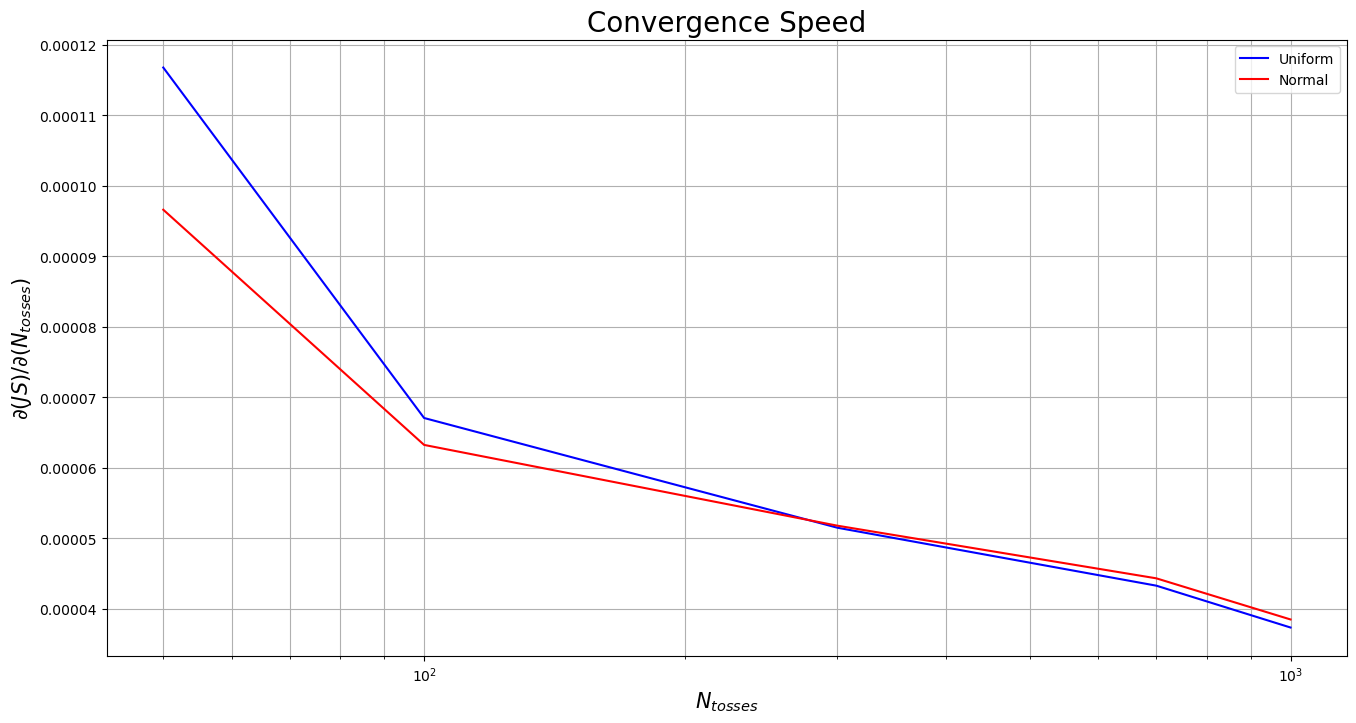

In [6]:
#Plotting

fig,ax = plt.subplots(figsize=(16,8))
ax.plot(plots[1:], uniform_vels, color='blue',label='Uniform')
ax.plot(plots[1:], normal_vels, color='red',label='Normal')
ax.legend()
ax.set_xlabel('$N_{tosses}$',fontsize=15)
ax.set_ylabel('$\partial ( JS ) / \partial (N_{tosses})$',fontsize=15)
ax.set_title('Convergence Speed',fontsize=20)
ax.set_xscale('log')
ax.xaxis.grid(True, which='both')
ax.yaxis.grid(True, which='major')

### Exercise 2

Politician $A$ makes a statement about some issue you knew nothing about before. Let’s call such proposition $S$ and assume your starting prior on $S$ is uniform with $0.5$ probability of $S$ being either true or false. Update your probability of $S$ being true, knowing that you trust Mr. $A$ to tell the truth with probability $prob(A_T)=4/5$. At this point Mr $B$ - another politician - declares that he agrees with Mr $A$ on $S$ being true. You trust Mr. $B$ much less, and believe that the probability of him to lie is $prob(B_T)=3/4$.
What is your final degree of belief in proposition $S$?

### Solution

In [7]:
def normalize(post):
    area = np.sum(post)
    return (post/area)

beliefs = ['False', 'True']
p_of_S = np.array([0.5,0.5])
p_of_A_given_S = np.array([0.2,0.8])
p_of_B_given_S = np.array([0.75,0.25])
p_of_A = p_of_A_given_S * p_of_S + (1 - p_of_A_given_S) * (1 - p_of_S)

p_of_S_given_A = ((p_of_A_given_S * p_of_S) / p_of_A).round(decimals = 2)

p_of_B = p_of_B_given_S * p_of_S_given_A + (1 - p_of_B_given_S) * (1 - p_of_S_given_A)
p_of_S_given_B = ((p_of_B_given_S * p_of_S_given_A) / p_of_B).round(decimals = 2)

print('After what A said my beliefs are: {0}: {1} | {2}: {3} \n'.format(beliefs[0], p_of_S_given_A[0], beliefs[1], p_of_S_given_A[1]))
print('After what B said my beliefs are: {0}: {1} | {2}: {3}'.format(beliefs[0], p_of_S_given_B[0], beliefs[1], p_of_S_given_B[1],2))

After what A said my beliefs are: False: 0.2 | True: 0.8 

After what B said my beliefs are: False: 0.43 | True: 0.57


### Exercise 3

You are tested for a dangerous disease named ”Bacillum Bayesianum” ($BB$). You test positive to $BB$. You know that the general incidence of $BB$ in the population is $1\%$. Moreover, you know that your test has a false negative probability of $5\%$ (false negative: you have $BB$ but the test scores negative), and a false positive rate also of $5\%$ (false positive: you do not have $BB$, but the test scores positive). What is the probability that you have actually contracted $BB$?

### Solution

In [8]:
def normalize(post):
    area = np.sum(post)
    return (post/area)

beliefs = ['False', 'True']
p_of_BB = np.array([0.99,0.01])
p_of_not_T_given_BB = np.array([0.95,0.05])
p_of_T_given_BB = np.array([1,1])-p_of_not_T_given_BB
p_of_T_given_not_BB = np.array([0.95,0.05])
p_of_T = p_of_T_given_BB * p_of_BB + p_of_T_given_not_BB * (1 - p_of_BB)

p_of_BB_given_T = ((p_of_T_given_BB * p_of_BB) / p_of_T).round(decimals = 3)


print('My belief about me having the BB given I tested positive is: {0}: {1} | {2}: {3} \n'.format(beliefs[0], p_of_BB_given_T[0], beliefs[1], p_of_BB_given_T[1]))

My belief about me having the BB given I tested positive is: False: 0.839 | True: 0.161 

